In [1]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import pickle

from torch.nn.utils.rnn import pad_sequence

In [2]:
def plot(COST,ACC):
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [3]:
def plot_embdings(my_embdings,name,vocab):
  
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [4]:


def plot_tras(words, model):
    # Tokenize the input words using a tokenizer function
    tokens = tokenizer(words)

    # Define the model's embedding dimension (d_model)
    d_model = 100

    # Convert the input words to a PyTorch tensor and move it to the specified device
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    x_ = model.emb(x) * math.sqrt(d_model)

    # Apply the model's positional encoder to the embeddings
    x = model.pos_encoder(x_)

    # Extract projection weights for query, key, and value from the model's state_dict
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:embed_dim].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

    # Calculate query (Q), key (K), and value (V) matrices
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate attention scores using dot-product attention
    scores = Q @ K.T

    # Set row and column labels for the attention matrix
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Dot-Product Attention")
    plt.show()

    # Apply softmax to the attention scores and create a heatmap
    att = nn.Softmax(dim=1)(scores)
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Scaled Dot-Product Attention")
    plt.show()

    # Calculate the attention head by multiplying softmax scores with values (V)
    head = nn.Softmax(dim=1)(scores) @ V

    # Visualize the embeddings and attention heads using t-SNE
    tsne(x_, tokens, title="Embeddings")
    tsne(head, tokens, title="Attention Heads")


def tsne(embeddings, tokens, title="Embeddings"):
    # Initialize t-SNE with 2 components and a fixed random state
    tsne = TSNE(n_components=2, random_state=0)

    # Fit t-SNE to the embeddings (converting from GPU if necessary)
    tsne_result = tsne.fit_transform(embeddings.squeeze(0).cpu().detach().numpy())

    # Create a scatter plot of the t-SNE results
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

    # Set a title for the plot
    plt.title(title)

    # Add labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        # Place the label text at the corresponding t-SNE coordinates
        plt.text(tsne_result[j, 0], tsne_result[j, 1], label)

    plt.show()

In [5]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [6]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [7]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

In [8]:
sequences = [torch.tensor([j for j in range(1,i)]) for i in range(2,10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

In [9]:
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


In [10]:
my_tokens='he painted the car red he painted the red car'

my_index=text_pipeline(my_tokens)
my_index

embedding_dim=3

vocab_size=len(vocab)
print(vocab_size)

embedding = nn.Embedding(vocab_size, embedding_dim)

27


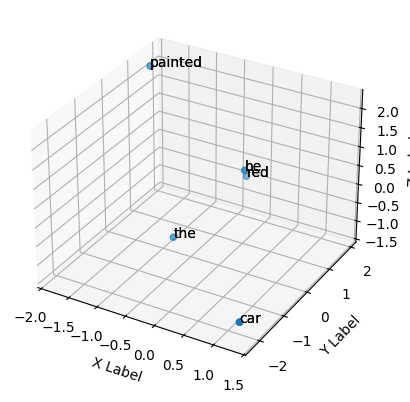

In [11]:
my_embdings=embedding(torch.tensor(my_index)).detach().numpy()
plot_embdings(my_embdings,tokenizer(my_tokens),vocab)

In [12]:
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
position

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.]])

In [13]:
d_model=3
pe = torch.zeros(vocab_size,d_model )

In [14]:
pe=torch.cat((position, position, position), 1)
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

In [15]:
samples,dim=my_embdings.shape
samples,dim

(10, 3)

In [16]:
pos_embding=my_embdings+pe[0:samples,:].numpy()

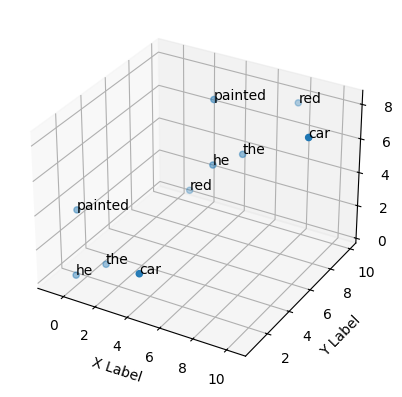

In [17]:
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

In [18]:
pos_embding[3]# add -3 to get original embedding

array([4.3005724 , 0.73533845, 1.9615332 ], dtype=float32)

In [19]:
pos_embding[-1]#add -9 original embedding

array([10.300572,  6.735338,  7.961533], dtype=float32)

In [20]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

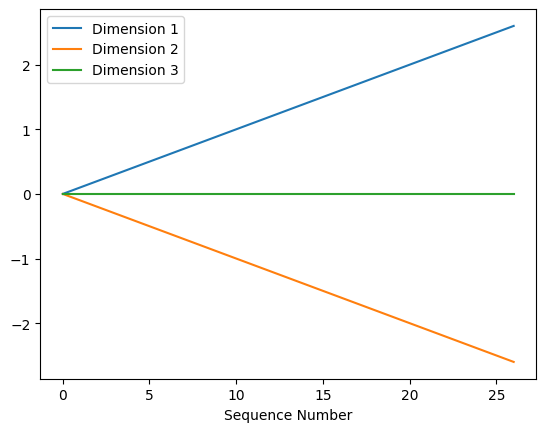

In [21]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

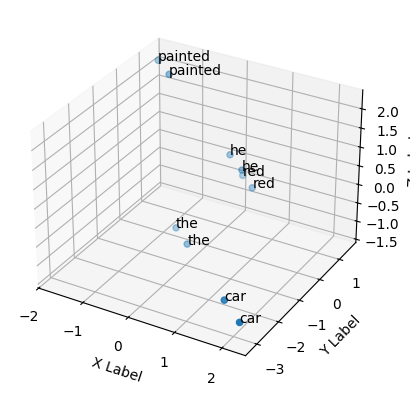

In [22]:
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

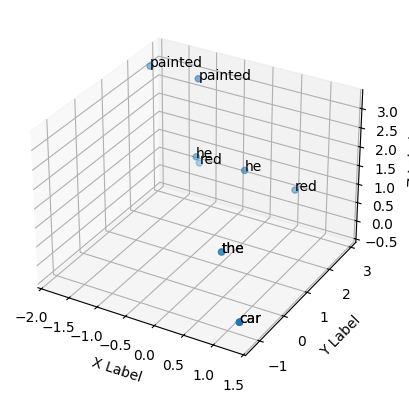

In [23]:
pe=torch.cat((torch.sin(2*3.14*position/6), 0*position+1, 0*position+1), 1)
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

In [24]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

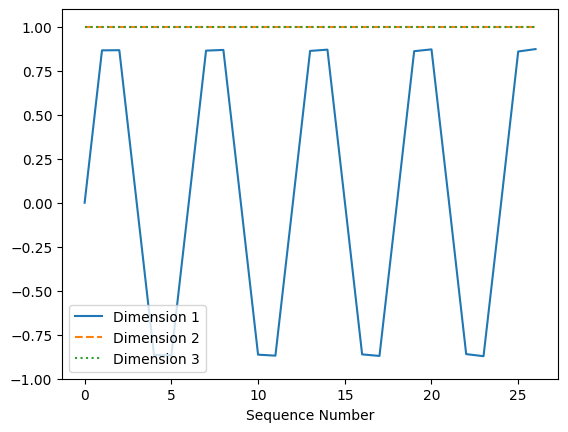

In [25]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

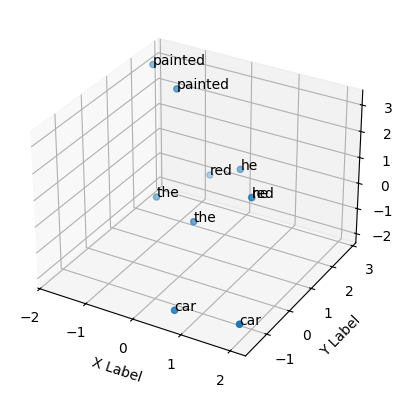

In [26]:
pe=torch.cat((torch.cos(2*3.14*position/25), torch.sin(2*3.14*position/25),  torch.sin(2*3.14*position/5)), 1)
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

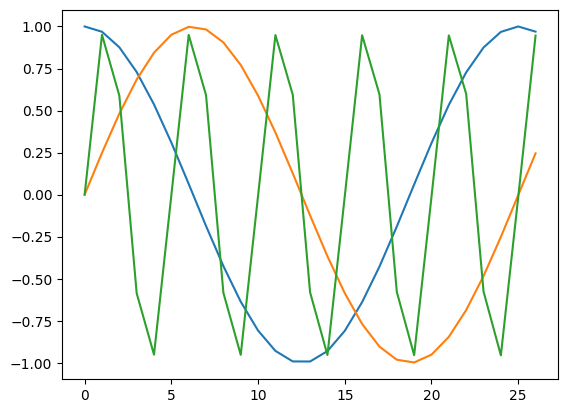

In [27]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

In [28]:
from torch import nn

class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [29]:
my_embdings=embedding(torch.tensor(my_index))
my_embdings

tensor([[-0.0456,  1.1773,  0.2838],
        [-1.8315,  1.3891,  2.2288],
        [-0.8852,  0.1620, -1.3319],
        [ 1.3006, -2.2647, -1.0385],
        [-0.3142,  1.9241, -0.4095],
        [-0.0456,  1.1773,  0.2838],
        [-1.8315,  1.3891,  2.2288],
        [-0.8852,  0.1620, -1.3319],
        [-0.3142,  1.9241, -0.4095],
        [ 1.3006, -2.2647, -1.0385]], grad_fn=<EmbeddingBackward0>)

In [30]:
my_embdings.shape

torch.Size([10, 3])

In [31]:
encoder_layer=nn.TransformerEncoderLayer(
            d_model=3,
            nhead=1,
            dim_feedforward=1,
            dropout=0,
        )

In [32]:
out=encoder_layer(my_embdings)
out

tensor([[-1.1586,  1.2816, -0.1229],
        [-1.3259,  0.2368,  1.0891],
        [-0.8497,  1.4039, -0.5542],
        [ 1.3916, -0.9137, -0.4780],
        [-1.0276,  1.3552, -0.3277],
        [-1.1586,  1.2816, -0.1229],
        [-1.3259,  0.2368,  1.0891],
        [-0.8497,  1.4039, -0.5542],
        [-1.0276,  1.3552, -0.3277],
        [ 1.3916, -0.9137, -0.4780]], grad_fn=<NativeLayerNormBackward0>)

In [33]:
out.mean(dim=1)

tensor([-7.4506e-09, -3.9736e-08,  0.0000e+00, -5.9605e-08,  9.9341e-09,
        -7.4506e-09, -3.9736e-08,  0.0000e+00,  9.9341e-09, -5.9605e-08],
       grad_fn=<MeanBackward1>)

In [34]:
params_dict = encoder_layer.state_dict()
# Print the parameter names and shapes
for name, param in params_dict.items():
    print(name, param.shape)

self_attn.in_proj_weight torch.Size([9, 3])
self_attn.in_proj_bias torch.Size([9])
self_attn.out_proj.weight torch.Size([3, 3])
self_attn.out_proj.bias torch.Size([3])
linear1.weight torch.Size([1, 3])
linear1.bias torch.Size([1])
linear2.weight torch.Size([3, 1])
linear2.bias torch.Size([3])
norm1.weight torch.Size([3])
norm1.bias torch.Size([3])
norm2.weight torch.Size([3])
norm2.bias torch.Size([3])


In [35]:
embed_dim=3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

In [36]:
Q=my_embdings@q_proj_weight
K=my_embdings@k_proj_weight
V=my_embdings@v_proj_weight

In [37]:
scores=Q@K.T/np. sqrt(embed_dim)
scores

tensor([[ 0.0517, -0.0070, -0.0133, -0.0576,  0.0818,  0.0517, -0.0070, -0.0133,
          0.0818, -0.0576],
        [-0.4341, -1.3823,  0.5291,  1.0756, -0.3284, -0.4341, -1.3823,  0.5291,
         -0.3284,  1.0756],
        [ 0.1651,  0.0471,  0.0813, -0.2625,  0.3144,  0.1651,  0.0471,  0.0813,
          0.3144, -0.2625],
        [ 0.0988,  0.6989, -0.2816, -0.3852, -0.0453,  0.0988,  0.6989, -0.2816,
         -0.0453, -0.3852],
        [ 0.2148,  0.1591, -0.0393, -0.3411,  0.3274,  0.2148,  0.1591, -0.0393,
          0.3274, -0.3411],
        [ 0.0517, -0.0070, -0.0133, -0.0576,  0.0818,  0.0517, -0.0070, -0.0133,
          0.0818, -0.0576],
        [-0.4341, -1.3823,  0.5291,  1.0756, -0.3284, -0.4341, -1.3823,  0.5291,
         -0.3284,  1.0756],
        [ 0.1651,  0.0471,  0.0813, -0.2625,  0.3144,  0.1651,  0.0471,  0.0813,
          0.3144, -0.2625],
        [ 0.2148,  0.1591, -0.0393, -0.3411,  0.3274,  0.2148,  0.1591, -0.0393,
          0.3274, -0.3411],
        [ 0.0988,  

In [38]:
head=nn.Softmax(dim=1)(scores)@V
head

tensor([[-0.0384, -0.0719, -0.4827],
        [ 0.4176, -0.3850,  0.9264],
        [-0.0455, -0.0712, -0.6274],
        [-0.4233,  0.1810, -1.1497],
        [-0.0990, -0.0252, -0.7389],
        [-0.0384, -0.0719, -0.4827],
        [ 0.4176, -0.3850,  0.9264],
        [-0.0455, -0.0712, -0.6274],
        [-0.0990, -0.0252, -0.7389],
        [-0.4233,  0.1810, -1.1497]], grad_fn=<MmBackward0>)

In [39]:
transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2)

In [40]:
params_dict = transformer_encoder.state_dict()
for name, param in params_dict.items():
    print(name, param.shape)

layers.0.self_attn.in_proj_weight torch.Size([9, 3])
layers.0.self_attn.in_proj_bias torch.Size([9])
layers.0.self_attn.out_proj.weight torch.Size([3, 3])
layers.0.self_attn.out_proj.bias torch.Size([3])
layers.0.linear1.weight torch.Size([1, 3])
layers.0.linear1.bias torch.Size([1])
layers.0.linear2.weight torch.Size([3, 1])
layers.0.linear2.bias torch.Size([3])
layers.0.norm1.weight torch.Size([3])
layers.0.norm1.bias torch.Size([3])
layers.0.norm2.weight torch.Size([3])
layers.0.norm2.bias torch.Size([3])
layers.1.self_attn.in_proj_weight torch.Size([9, 3])
layers.1.self_attn.in_proj_bias torch.Size([9])
layers.1.self_attn.out_proj.weight torch.Size([3, 3])
layers.1.self_attn.out_proj.bias torch.Size([3])
layers.1.linear1.weight torch.Size([1, 3])
layers.1.linear1.bias torch.Size([1])
layers.1.linear2.weight torch.Size([3, 1])
layers.1.linear2.bias torch.Size([3])
layers.1.norm1.weight torch.Size([3])
layers.1.norm1.bias torch.Size([3])
layers.1.norm2.weight torch.Size([3])
layers.1

In [41]:
train_iter= AG_NEWS(split="train")

In [42]:
y,text= next(iter(train_iter ))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [43]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [44]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

In [45]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [46]:
vocab(["age","hello"])

[2120, 12544]

In [47]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [49]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

In [50]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [51]:
label,seqence=next(iter(valid_dataloader ))

In [52]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        
        self,
        vocab_size,
        num_class,
        embedding_dim=100,
        nhead=5,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        self.emb = nn.Embedding(vocab_size,embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [53]:
y,x=next(iter(train_dataloader))

In [54]:
x

tensor([[  205,  2119,   110,  ...,     0,     0,     0],
        [ 1344,    61, 76300,  ...,     0,     0,     0],
        [   10,   431,   374,  ...,     0,     0,     0],
        ...,
        [  133,  5914, 10469,  ...,     0,     0,     0],
        [  679,   384,  1255,  ...,     0,     0,     0],
        [39415,     5,  4357,  ...,     0,     0,     0]])

In [55]:
emsize=64

In [56]:
vocab_size=len(vocab)
vocab_size

95811

In [57]:
num_class

4

In [58]:
model = Net(vocab_size=vocab_size,num_class=4).to(device)
model

Net(
  (emb): Embedding(95811, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

In [59]:
predicted_label=model(x)

In [60]:
predicted_label.shape

torch.Size([64, 4])

In [61]:
x.shape

torch.Size([64, 81])

In [62]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [63]:
predict("I like sports and stuff",text_pipeline )

'Business'

In [64]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [65]:
evaluate(test_dataloader, model)

0.2501315789473684

In [66]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
EPOCHS = 10
cum_loss_list = []
acc_epoch = []
acc_old = 0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss = 0
    for idx, (label, text) in enumerate(train_dataloader):
        optimizer.zero_grad()
        label, text = label.to(device), text.to(device)

        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss += loss.item()
    print("Loss", cum_loss)

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader, model)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
        acc_old = accu_val
        torch.save(model.state_dict(), 'my_model.pth')

save_list_to_file(lst=cum_loss_list, filename="loss.pkl")
save_list_to_file(lst=acc_epoch, filename="acc.pkl")


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
cum_loss_list=load_list_from_file("loss.pkl")
acc_epoch=load_list_from_file("acc.pkl")

In [ ]:
pretrained_model_path = 'my_model.pth'
model_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))

In [ ]:
plot(cum_loss_list,acc_epoch)

In [ ]:
evaluate(test_dataloader, model_)

In [ ]:
sample=15

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)

In [ ]:
sample=1

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)

In [ ]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [ ]:
result = predict(article, text_pipeline)